In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from PIL import Image
import cv2
import math

In [3]:
xs = np.arange(-10, 10, 0.1)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return max(0,x)

def relu_derivative(x):
    if x > 0:
        return 1
    else:
        return 0

def leaky_relu(x):
    if x > 0:
        return x
    else: 
        return 0.01*x
    
def leaky_relu_derivative(x):
    if x > 0:
        return 1
    else:
        return 0.01

y_sig = [sigmoid(x) for x in xs]
y_sig_deriv = [sigmoid_derivative(x) for x in xs]
y_relu = [relu(x) for x in xs]
y_relu_deriv = [relu_derivative(x) for x in xs]
y_leaky = [leaky_relu(x) for x in xs]
y_leaky_deriv = [leaky_relu_derivative(x) for x in xs]

In [4]:
g = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])

f = np.array([[1,2,3,4], [1,2,3,4], [1,2,3,4], [1,2,3,4]])

fg = convolve2d(f,g, mode='same',boundary='fill', fillvalue=0)

print(f)
print(g)

print(fg)

[[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]
[[-1  0  1]
 [-1  0  1]
 [-1  0  1]]
[[-4 -4 -4  6]
 [-6 -6 -6  9]
 [-6 -6 -6  9]
 [-4 -4 -4  6]]


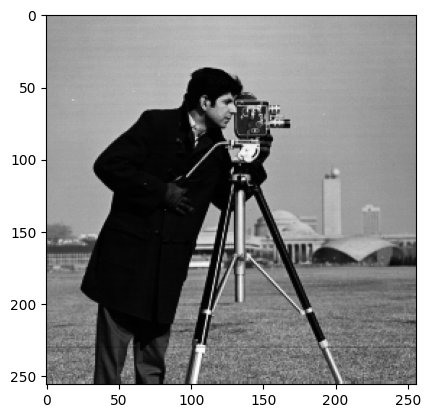

In [5]:
img = np.array(Image.open("/Users/leeannquynhdo/Datalogi/MSc_thesis/cameraman.png").convert('L'))
plt.imshow(img,cmap='gray')

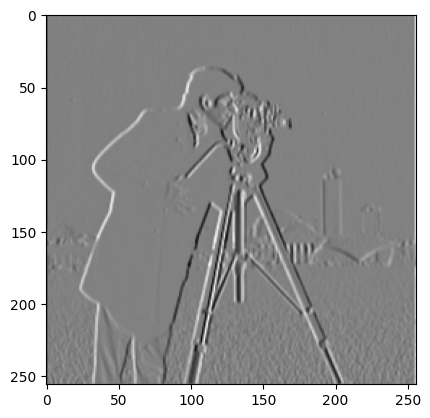

In [6]:
img_conv = convolve2d(img,g, mode='same',boundary='fill', fillvalue=0)
plt.imshow(img_conv, cmap='gray')

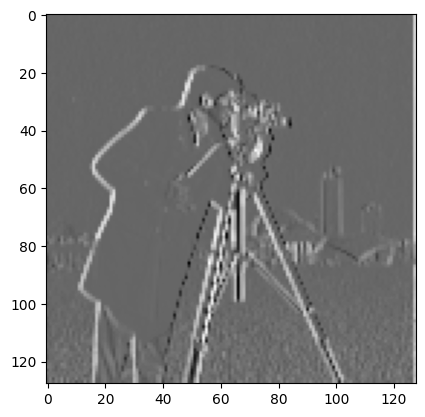

In [7]:

from skimage.measure import block_reduce

# Apply max pooling with a 2x2 pool size
pool_size = (2, 2)
result = block_reduce(img_conv, pool_size, np.max)

plt.imshow(result, cmap='gray')

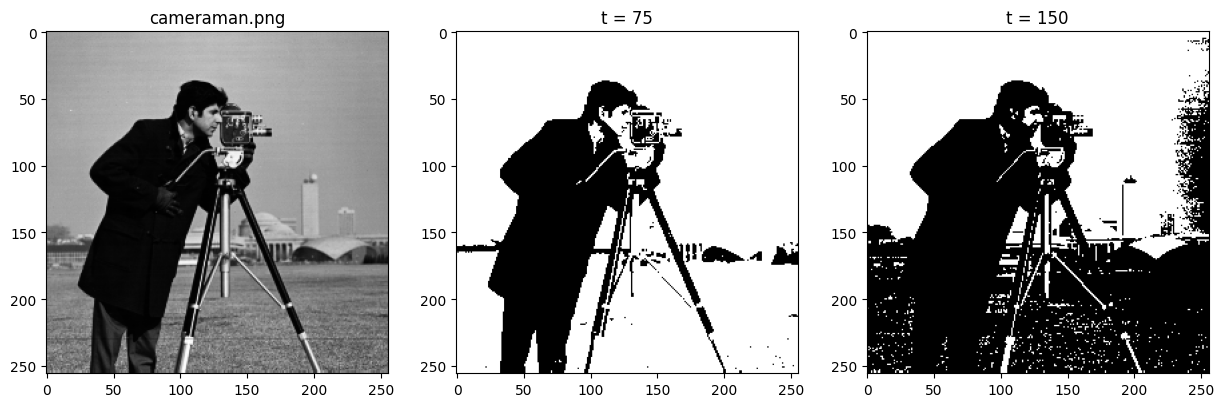

In [8]:
seg_img_100 = img >= 75
seg_img_150 = img >= 150

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].set_title('cameraman.png')
ax[0].imshow(img, cmap='gray')
ax[1].set_title('t = 75')
ax[1].imshow(seg_img_100, cmap='gray')
ax[2].set_title('t = 150')
ax[2].imshow(seg_img_150, cmap='gray')



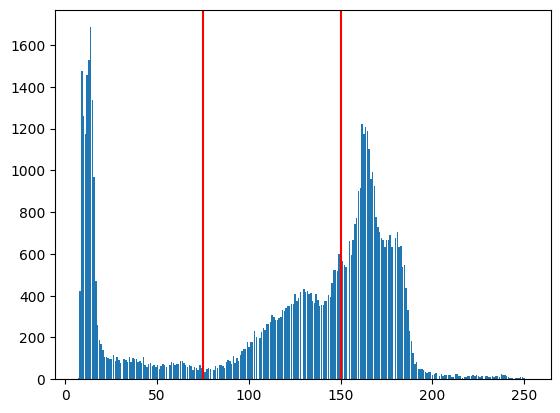

In [9]:
img_hist, bin_edges = np.histogram(img, bins=256)

plt.bar(bin_edges[0:-1], img_hist)
plt.axvline(x=75, color='r')
plt.axvline(x=150, color='r')
plt.show()

In [10]:
def otsu(im, th):
    # create the thresholded image
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1

    # compute weights
    nb_pixels = im.size
    nb_pixels1 = np.count_nonzero(thresholded_im)
    weight1 = nb_pixels1 / nb_pixels
    weight0 = 1 - weight1

    # if one of the classes is empty, eg all pixels are below or above the threshold, that threshold will not be considered
    # in the search for the best threshold
    if weight1 == 0 or weight0 == 0:
        return np.inf

    # find all pixels belonging to each class
    val_pixels1 = im[thresholded_im == 1]
    val_pixels0 = im[thresholded_im == 0]

    # compute variance of these classes
    var1 = np.var(val_pixels1) if len(val_pixels1) > 0 else 0
    var0 = np.var(val_pixels0) if len(val_pixels0) > 0 else 0

    return weight0 * var0 + weight1 * var1

# testing all thresholds from 0 to the maximum of the image
threshold_range = range(np.max(img)+1)
criterias = [otsu(img, th) for th in threshold_range]

# best threshold is the one minimizing the Otsu criteria
best_threshold = threshold_range[np.argmin(criterias)]


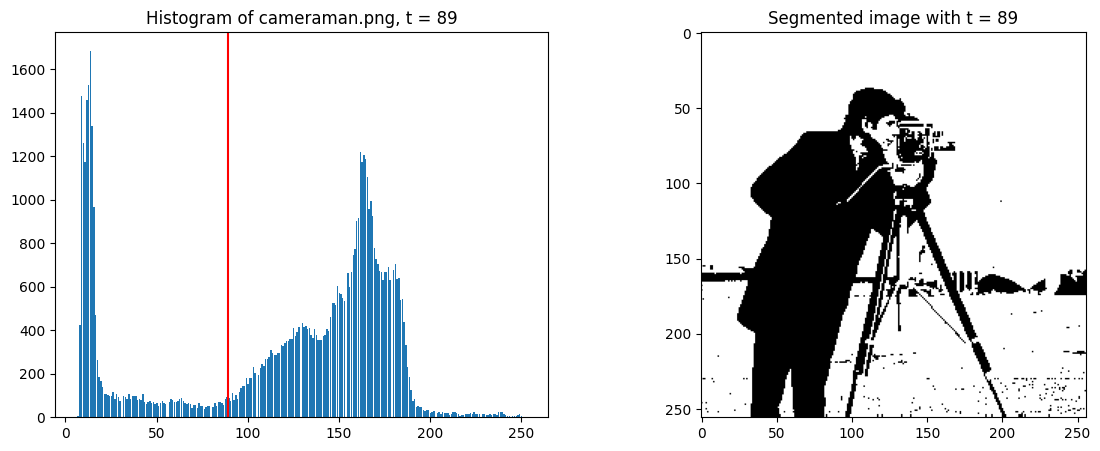

In [11]:
seg_img_otsu = img >= best_threshold

fig, ax = plt.subplots(1,2,figsize=(14,5))

ax[0].set_title(f'Histogram of cameraman.png, t = {best_threshold}')
ax[0].bar(bin_edges[0:-1], img_hist)
ax[0].axvline(x=best_threshold, color='r')
ax[1].set_title(f'Segmented image with t = {best_threshold}')
ax[1].imshow(seg_img_otsu, cmap='gray')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


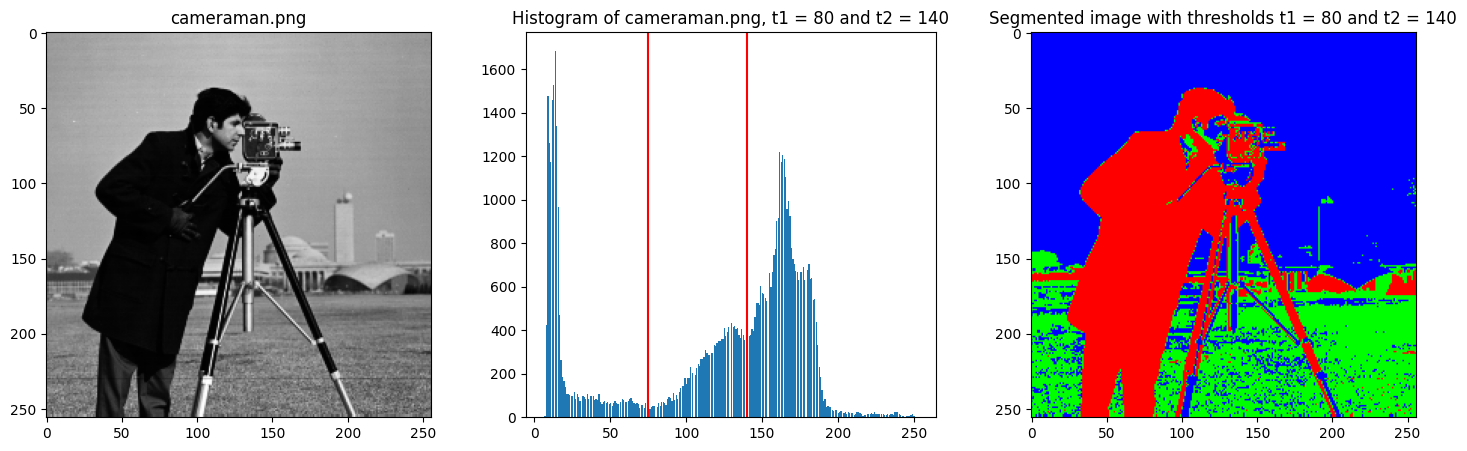

In [12]:
seg1 = (img <= 80)
seg2 = (img > 80) & (img <= 140)
seg3 = (img > 140)

all_seg = np.zeros((img.shape[0], img.shape[1], 3))

all_seg[seg1] = (200,0,0) # red
all_seg[seg2] = (0,200,0) # green
all_seg[seg3] = (0,0,200) # blue

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].set_title('cameraman.png')
ax[0].imshow(img, cmap='gray')
ax[1].set_title('Histogram of cameraman.png, t1 = 80 and t2 = 140')
ax[1].bar(bin_edges[0:-1], img_hist)
ax[1].axvline(x=75, color='r')
ax[1].axvline(x=140, color='r')
ax[2].set_title('Segmented image with thresholds t1 = 80 and t2 = 140')
ax[2].imshow(all_seg)
plt.show()

In [13]:
# Create a black image of size 256x256
disk = np.zeros((256, 256), dtype=np.uint8)

# Calculate the center of the image
center_x = 128
center_y = 128

# Calculate the radius of the disk
radius = 80

# Draw a white disk on the image
cv2.circle(disk, (center_x, center_y), radius, 255, -1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

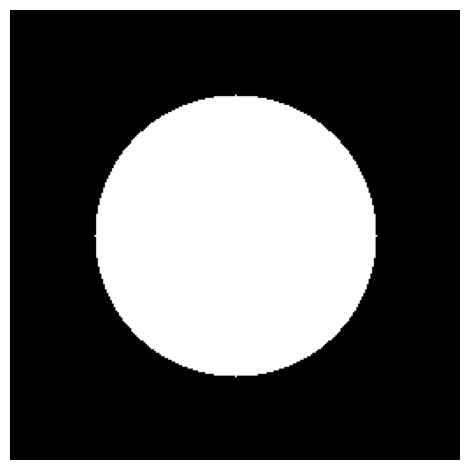

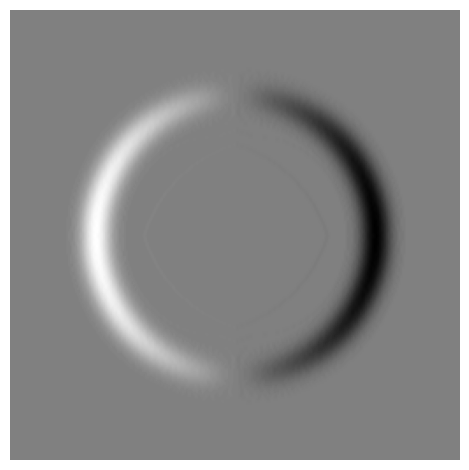

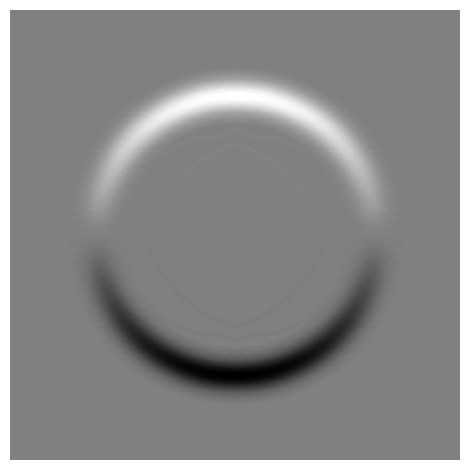

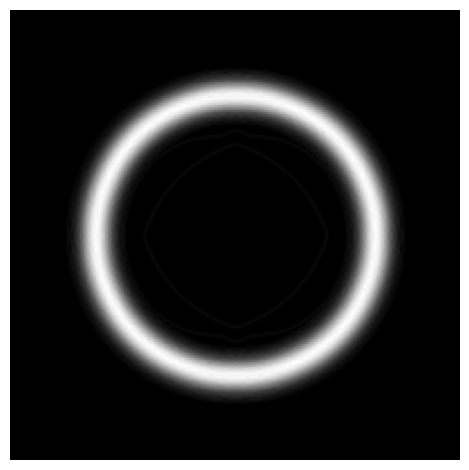

In [18]:
from scipy.ndimage import gaussian_filter
# Compute gradients in the x and y directions using Sobel operator
gradient_x = cv2.Sobel(gaussian_filter(disk, sigma=6), cv2.CV_64F, 1, 0, ksize=3)
gradient_y = cv2.Sobel(gaussian_filter(disk, sigma=6), cv2.CV_64F, 0, 1, ksize=3)

gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

gms = gradient_x**2 + gradient_y**2




plt.imshow(disk, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()
plt.imshow(gradient_x, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()
plt.imshow(gradient_y, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()
plt.imshow(gradient_magnitude, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

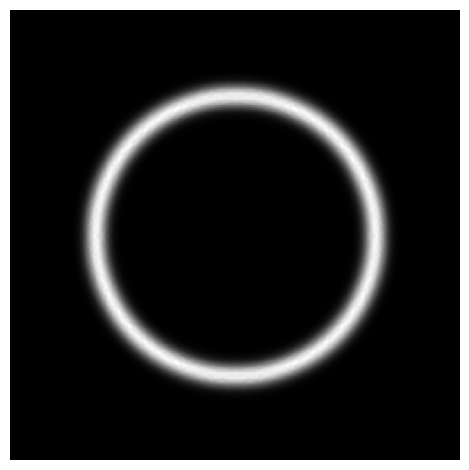

In [19]:
plt.imshow(gms, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

In [49]:
img0 = np.array(Image.open("/Users/leeannquynhdo/Datalogi/MSc_thesis/unet_implementation/train_images/train_image_0.tif"))
img1 = np.array(Image.open("/Users/leeannquynhdo/Datalogi/MSc_thesis/unet_implementation/train_images/train_image_1.tif"))
img36 = np.array(Image.open("/Users/leeannquynhdo/Datalogi/MSc_thesis/unet_implementation/train_images/train_image_36.tif"))


In [4]:
print(len(np.unique(img0)))
print(np.count_nonzero(img2==255))

249
1146560


In [50]:
hist_0, bins_0 = np.histogram(img0, bins=4069)
hist_1, bins_1 = np.histogram(img1, bins=4069)
hist_36, bins_36 = np.histogram(img36, bins=4096)

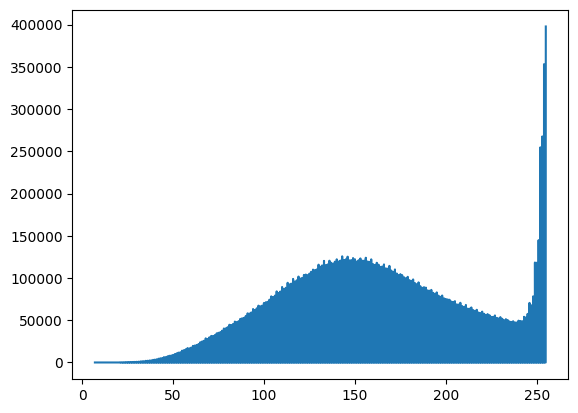

In [52]:
plt.plot(bins_0[0:-1], hist_0)
plt.savefig('report_images/hist0.png', dpi=500, bbox_inches='tight')
plt.show()

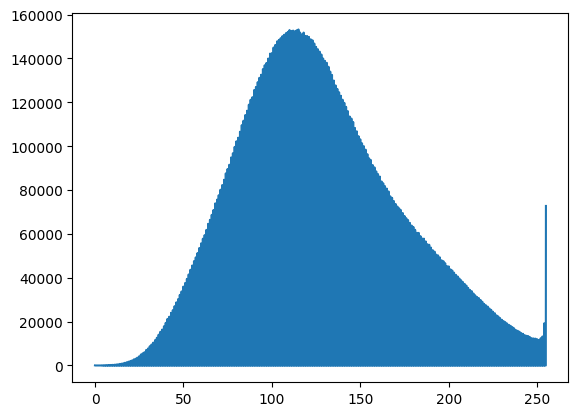

In [53]:
plt.plot(bins_1[0:-1], hist_1)
plt.savefig('report_images/hist1.png', dpi=500, bbox_inches='tight')
plt.show()

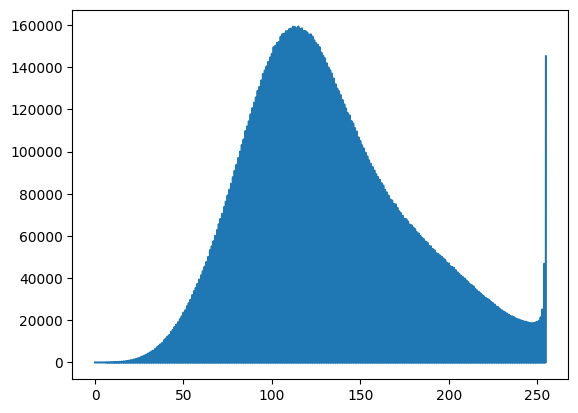

In [54]:
plt.plot(bins_36[0:-1], hist_36)
plt.savefig('report_images/hist36.png', dpi=500, bbox_inches='tight')
plt.show()